In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import scipy.stats as stat
import empiricaldist as ed

## Gamma and Poisson

As we increase the number of parameters, the number of points in the grid grows (literally) exponentially. With more than 3-4 parameters, grid methods become impractical.

In World Cup Problem (poisson process), I presented three reasons to use a gamma distribution for the prior and said there was a fourth reason I would reveal later. Well, now is the time.

The other reason I chose the gamma distribution is that it is the “conjugate prior” of the Poisson distribution, so-called because the two distributions are connected or coupled, which is what “conjugate” means. Lets derivate gamma update through conjugate parameters. To understand how that works, we’ll write the PDF of the gamma prior and the PMF of the Poisson likelihood, then multiply them together, because that’s what the Bayesian update does.

Remember originally we did computed likelihood with poisson distribution, multiplied gamma prior wwith pmf poisson and normalized.

**Gamma PDF: lambda\*\*(alpha-1) \* exp(-lambda*beta)** -> omitting the normalization factor, since we plan to normalize the posterior anyway.

Now, suppose tam scores k goals in t games. The probability. of this data is given by Poisson distributin with k, t, lambda parameters.

**lambda\*\*k \*exp(-lambda*t)** -> omitting the normalization factor, since we plan to normalize the posterior anyway. And it makes clearer that Poisson ang Gamma have thesame functional form. When we multiply them together, we can pair up the factors and add up the exponents. The result is the unnormalized posterior distribution:

**lambda\*\*(alpha-1+k) \* exp(-lambda \* (beta+t))** -> which we can recognize as an unnormalized gamma distribution with parameters *alpha+k* and *beta+t*.

This derivation provides insight into what the parameters of the posterior distribution mean: alpha reflects the number of events that have occurred; beta reflects the elapsed time.

In [2]:
def make_gamma_dist(alpha, beta):
    """Makes a gamma object."""
    dist = stat.gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

def update_gamma(prior, data):
    """Update a gamma prior."""
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta)


In [3]:
# likelihood  update
alpha = 1.4
dist = stat.gamma(alpha)


lams = np.linspace(0, 10, 101)
prior = u.pmf_from_dist(dist, lams)

k = 4
likelihood = stat.poisson(lams).pmf(k)

posterior = prior * likelihood
posterior.normalize()

0.05015532557804499

In [4]:
def make_gamma_dist(alpha, beta):
    """Makes a gamma object."""
    dist = stat.gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

def update_gamma(prior, data):
    """Update a gamma prior."""
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta)

In [5]:
# conjugate update
alpha = 1.4
beta = 1

prior_gamma = make_gamma_dist(alpha, beta)
prior_gamma.mean()

data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

posterior_conjugate = u.pmf_from_dist(posterior_gamma, lams)

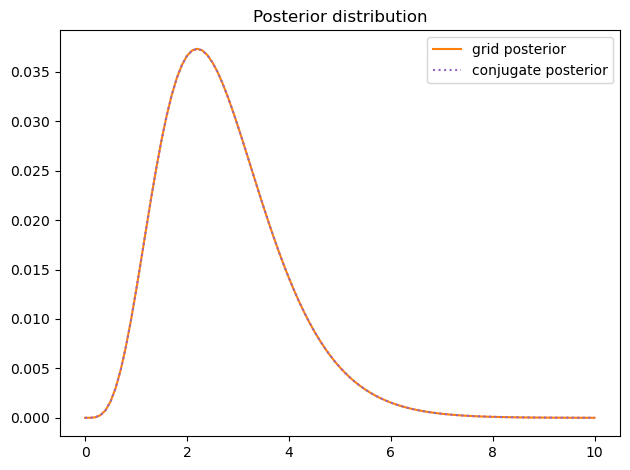

In [7]:
posterior.plot(label='grid posterior', color='C1')
posterior_conjugate.plot(label='conjugate posterior', 
                         color='C4', ls=':')

u.decorate(title='Posterior distribution')

## Binomal and Beta Distribution

**PDF of Beta Distribution: x\*\*(alpha-1)\*(1-x)\*\*(beta-1)**

**PMF of Binom Distribution: x\*\*(k)\*(1-x)\*\*(n-k)**

Multipy -> **x\*\*(alpha-1+k)\*(1-x)\*\*(beta-1+n-k)**
->> which we recognize as an unnormalized beta distribution with parameters *alpha+k* and *beta+n-k*.

In [8]:
# Likelihood update - Euro problem

xs = np.linspace(0, 1, 101)
uniform = u.make_uniform(xs, 'uniform')

k, n = 140, 250
xs = uniform.qs
likelihood = stat.binom.pmf(k, n, xs)

posterior = uniform * likelihood
posterior.normalize()

0.003944617569326651

In [9]:
def make_beta(alpha, beta):
    """Makes a beta object."""
    dist = stat.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

In [10]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)

def update_beta(prior, data):
    """Update a beta distribution."""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

data = 140, 250
posterior_beta = update_beta(prior_beta, data)

posterior_conjugate = u.pmf_from_dist(posterior_beta, xs)

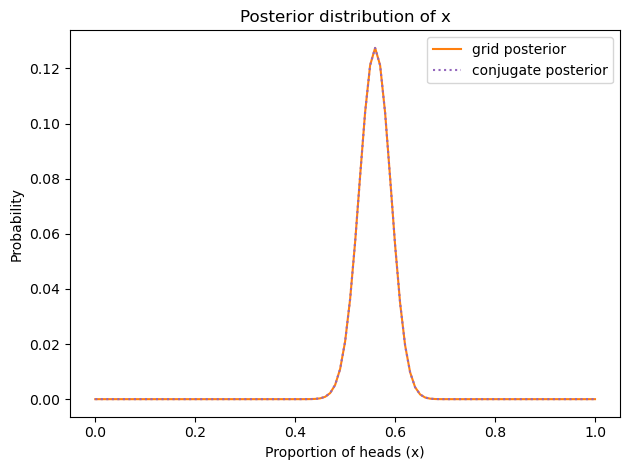

In [11]:
posterior.plot(label='grid posterior', color='C1')
posterior_conjugate.plot(label='conjugate posterior',
                        color='C4', ls=':')

u.decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title='Posterior distribution of x')

## Multinomal and Dirichlet Distribution

During the tour, we see 3 lions, 2 tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, what is the probability that the next animal we see is a bear?

To answer this question, we’ll use the data to estimate the prevalence of each species, that is, what fraction of the animals belong to each species. If we know the prevalences, we can use the multinomial distribution to compute the probability of the data. For example, suppose we know that the fraction of lions, tigers, and bears is 0.4, 0.3, and 0.3, respectively.

In [12]:
data = 3, 2, 1
n = np.sum(data)
ps = 0.4, 0.3, 0.3

stat.multinomial.pmf(data, n, ps)

0.10368

Now, we could choose a prior for the prevalences and do a Bayesian update using the multinomial distribution to compute the probability of the data.

But there’s an easier way, because the multinomial distribution has a conjugate prior: the Dirichlet distribution.

### Dirichlet Distribution

The Dirichlet distribution is a multivariate distribution. In a Dirichlet distribution, the quantities are vectors of probabilities, *x*, and the parameter is a vector, *alpha*.

In [25]:
alpha = 1, 2, 3
dist = stat.dirichlet(alpha)

dist.rvs() # result is bounded 0 to 1 and sums up to 1 -> can be interpreted as probs for mutually exclusive and collectively exhaustive.

array([[0.05226655, 0.40038999, 0.54734347]])

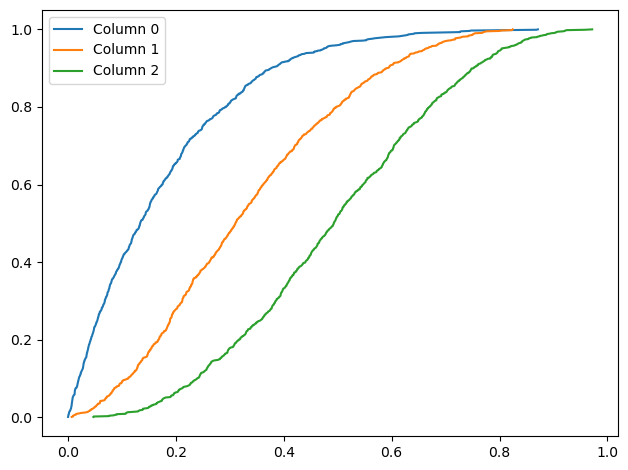

In [26]:
sample = dist.rvs(1000)

cdfs = [ed.Cdf.from_seq(col) 
        for col in sample.transpose()]

for i, cdf in enumerate(cdfs):
    label = f'Column {i}'
    cdf.plot(label=label)
    
u.decorate()

Column 0, which corresponds to the lowest parameter, contains the lowest probabilities. Column 2, which corresponds to the highest parameter, contains the highest probabilities.

As it turns out, these marginal distributions are beta distributions. The following function takes a sequence of parameters, alpha, and computes the marginal distribution of variable i:

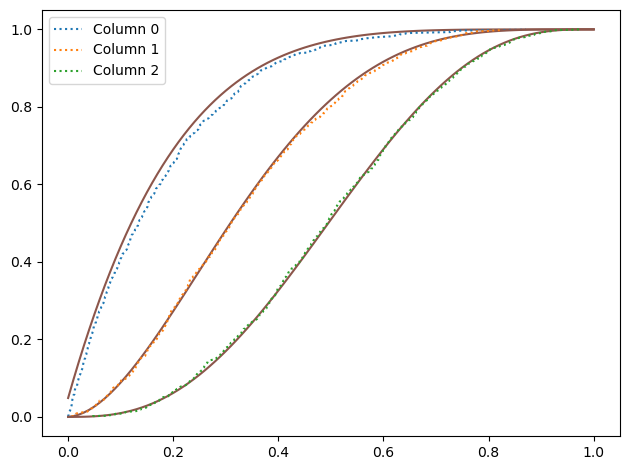

In [27]:
def marginal_beta(alpha, i):
    """Compute the ith marginal of a Dirichlet distribution."""
    total = np.sum(alpha)
    return make_beta(alpha[i], total-alpha[i])

marginals = [marginal_beta(alpha, i)
             for i in range(len(alpha))]

xs = np.linspace(0, 1, 101)

for i in range(len(alpha)):
    label = f'Column {i}'
    
    pmf = u.pmf_from_dist(marginals[i], xs)
    pmf.make_cdf().plot(color='C5')
    
    cdf = cdfs[i]
    cdf.plot(label=label, ls=':')

u.decorate()

This confirms that the marginals of the Dirichlet distribution are beta distributions. And that’s useful because the Dirichlet distribution is the conjugate prior for the multinomial likelihood function.

If the prior distribution is Dirichlet with parameter vector alpha and the data is a vector of observations, data, the posterior distribution is Dirichlet with parameter vector alpha + data.


So why did we go to all the trouble of using grid algorithms?

Sadly, there are only a few problems we can solve with conjugate priors; in fact, this chapter includes most of the ones that are useful in practice.

For the vast majority of problems, there is no conjugate prior and no shortcut to compute the posterior distribution. That’s why we need grid algorithms and the methods in the next two chapters, Approximate Bayesian Computation (ABC) and Markov chain Monte Carlo methods (MCMC).

In [29]:
cdfs[0].mean(), cdfs[0].median(), 

(0.17328507812195196, array(0.13382493))

In [41]:
prior_alpha = np.array([1, 1, 1])
data = np.array([3, 2, 1])


posterior_alpha = prior_alpha + data

marginal_bear = marginal_beta(posterior_alpha, 2)
marginal_bear.mean()

0.2222222222222222

In [42]:
dist = stat.dirichlet(posterior_alpha)

In [43]:
index = ['lion', 'tiger', 'bear']
pd.DataFrame(dist.mean(), index, columns=['prob'])

,prob
lion,0.444444
tiger,0.333333
bear,0.222222


## Exercises

### 1

In the second version of the World Cup problem, the data we use for the update is not the number of goals in a game, but the time until the first goal. So the probability of the data is given by the exponential distribution rather than the Poisson distribution.

But it turns out that the gamma distribution is also the conjugate prior of the exponential distribution, so there is a simple way to compute this update, too. The PDF of the exponential distribution is a function ofv*t* with *lambda* as a parameter.

**lambda\*exp(-lambda\*t)**

Multiply the PDF of the gamma prior by this likelihood, confirm that the result is an unnormalized gamma distribution, and see if you can derive its parameters.

Write a few lines of code to update prior_gamma with the data from this version of the problem, which was a first goal after 11 minutes and a second goal after an additional 12 minutes.

Remember to express these quantities in units of games, which are approximately 90 minutes.

In [53]:
data = 11/90, 12/90

alpha = 1.4 + 1 + 1
beta = 1 + 11/90 + 12/90

posterior1 = make_gamma_dist(alpha, beta)

posterior2 = prior_gamma
for t in data:
    posterior2 = update_gamma(posterior2, (1, t))

<AxesSubplot:>

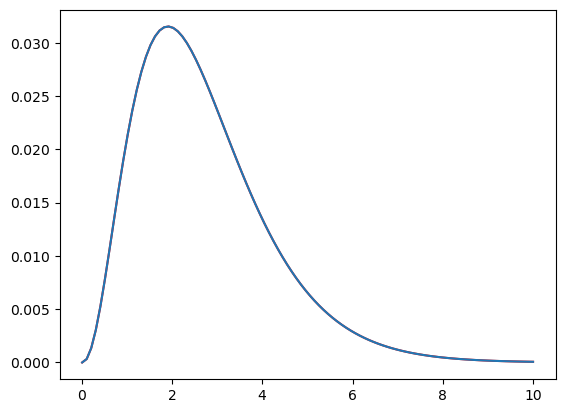

In [54]:
pmf1 = u.pmf_from_dist(posterior, np.linspace(0.01, 10, 100))
pmf2 = u.pmf_from_dist(posterior2, np.linspace(0.01, 10, 100))
pmf1.plot(color='red')
pmf2.plot()

In [55]:
pmf1.mean(), pmf2.mean()

(2.7030680532379687, 2.7030680532379687)

### 2

For problems like the Euro problem where the likelihood function is binomial, we can do a Bayesian update with just a few arithmetic operations, but only if the prior is a beta distribution.

If we want a uniform prior, we can use a beta distribution with alpha=1 and beta=1. But what can we do if the prior distribution we want is not a beta distribution? For example, in <<_TrianglePrior>> we also solved the Euro problem with a triangle prior, which is not a beta distribution.

In these cases, we can often find a beta distribution that is a good-enough approximation for the prior we want. See if you can find a beta distribution that fits the triangle prior, then update it using update_beta.

Use pmf_from_dist to make a Pmf that approximates the posterior distribution and compare it to the posterior we just computed using a grid algorithm. How big is the largest difference between them?

In [56]:

ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)
xs = uniform.qs

triangle = ed.Pmf(a, xs, name='triangle')
triangle.normalize()

k, n = 140, 250
likelihood = stat.binom.pmf(k, n, xs)

posterior = triangle * likelihood
posterior.normalize()

0.007008842590059086

0.5


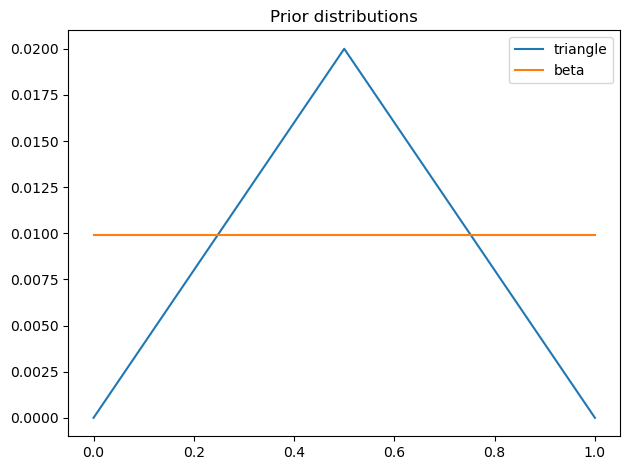

In [67]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
print(prior_beta.mean())

prior_pmf = u.pmf_from_dist(prior_beta, xs)

triangle.plot(label='triangle')
prior_pmf.plot(label='beta')

u.decorate(title='Prior distributions')

In [68]:
posterior_beta = update_beta(prior_beta, (k, n))

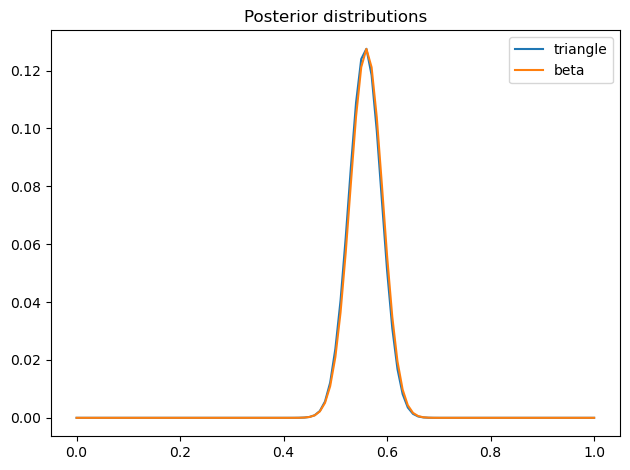

In [69]:
pmf = u.pmf_from_dist(posterior_beta, xs)

posterior.plot(label='triangle')
pmf.plot(label='beta')

u.decorate(title='Posterior distributions')

In [70]:
max(pmf - posterior) # 0.002 for alphaa=6, beta=6

0.005442088306718454

### 3



    You are buying a product online and you see three sellers offering the same product at the same price. One of them has a 100% positive rating, but with only 10 reviews. Another has a 96% positive rating with 50 total reviews. And yet another has a 93% positive rating, but with 200 total reviews.

    Which one should you buy from?

Let’s think about how to model this scenario. Suppose each seller has some unknown probability, x, of providing satisfactory service and getting a positive rating, and we want to choose the seller with the highest value of x.

This is not the only model for this scenario, and it is not necessarily the best. An alternative would be something like item response theory, where sellers have varying ability to provide satisfactory service and customers have varying difficulty of being satisfied.

But the first model has the virtue of simplicity, so let’s see where it gets us.

As a prior, I suggest a beta distribution with alpha=8 and beta=2. What does this prior look like and what does it imply about sellers?

Use the data to update the prior for the three sellers and plot the posterior distributions. Which seller has the highest posterior mean?

How confident should we be about our choice? That is, what is the probability that the seller with the highest posterior mean actually has the highest value of x?

Consider a beta prior with alpha=0.7 and beta=0.5. What does this prior look like and what does it imply about sellers?

Run the analysis again with this prior and see what effect it has on the results.


<AxesSubplot:>

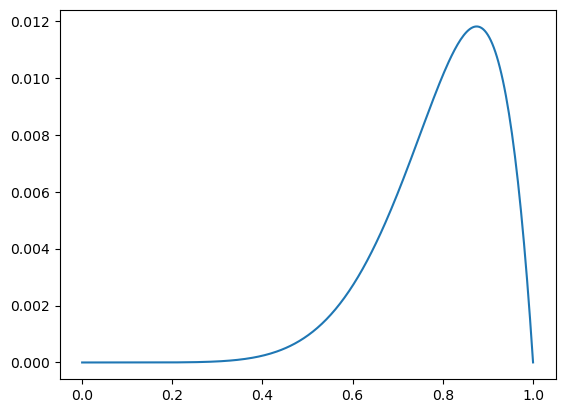

In [74]:
xs = np.linspace(1e-3, 0.99999, 300)
prior = make_beta(8, 2)
prior_pmf = u.pmf_from_dist(prior, xs)

prior_pmf.plot()

In [75]:
data = [
   #k, n
   (10, 10),
   (int(0.96*50), 50),
   (int(0.93*200), 200)
]

posteriors = []
for update in data:
   posteriors.append(
      update_beta(prior, update)
   )

0.9 [0.77279495 0.97994338]
Summary for 0. seller: None
0.933 [0.87302806 0.97660227]
Summary for 1. seller: None
0.924 [0.89307468 0.94987344]
Summary for 2. seller: None


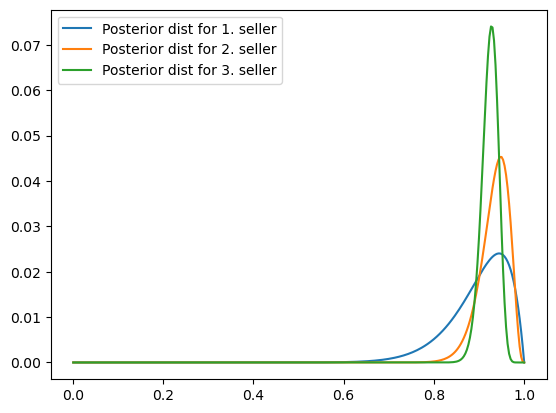

In [77]:
pmfs = []
for i, post in enumerate(posteriors):
    t = f"Posterior dist for {i+1}. seller"
    pmf = u.pmf_from_dist(post, xs)

    print(f'Summary for {i}. seller:', u.summarize(pmf))

    pmfs.append(pmf)

    pmf.plot(label=t)
    
plt.legend()
plt.show()

In [80]:
ed.Pmf.gt_dist(pmfs[1], pmfs[2]), ed.Pmf.gt_dist(pmfs[1], pmfs[0])

(0.6197545568372688, 0.6364232669785465)

In [90]:
iters = 100000
a = np.empty((3, iters))

for i in range(3):
    a[i] = posteriors[i].rvs(iters)

best = np.argmax(a, axis=0)
ed.Pmf.from_seq(best)

,probs
0,0.28834
1,0.47939
2,0.23227


In [89]:
# p = ed.Pmf([
#         ed.Pmf.gt_dist(pmfs[0], pmfs[2])* ed.Pmf.gt_dist(pmfs[0], pmfs[1]),
#         ed.Pmf.gt_dist(pmfs[1], pmfs[2])* ed.Pmf.gt_dist(pmfs[1], pmfs[0]),
#         ed.Pmf.gt_dist(pmfs[2], pmfs[0])* ed.Pmf.gt_dist(pmfs[2], pmfs[1]),
#     ], [1,2,3])
# p.normalize()
# p

,probs
1,0.193501
2,0.538884
3,0.267615
